In [1]:
# WE NEED TO RUN THAT SCRIPT 1 HOUR BEFORE DEADLINE!
HOLDOUT = 1  # number of hours to skip before the first prediction
TIMEZONE = 3

plt.style.use('bmh')

### Get the data

(1000, 5)


,open,high,low,close,volume
dt1,,,,,
2023-02-19 21:00:00,"1,686.98","1,687.14","1,682.07","1,685.97","12,684.47"
2023-02-19 22:00:00,"1,685.97","1,688.85","1,681.75","1,685.55","7,566.94"
2023-02-19 23:00:00,"1,685.54","1,685.55","1,680.19","1,682.65","2,163.67"


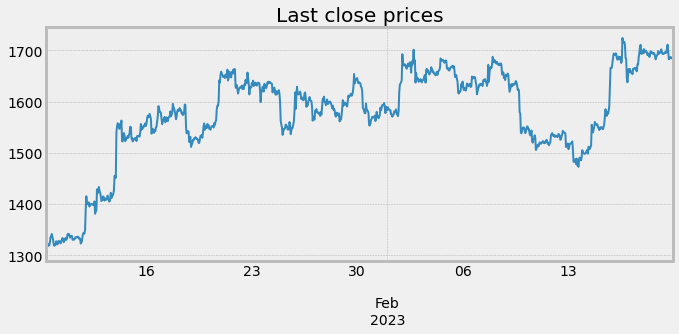

In [2]:
# get the data
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0 
df['dt1'] = [dt.fromtimestamp(x/1000) - relativedelta(hours=TIMEZONE) for x in df.dt1]
df.set_index('dt1', inplace = True)

print(df.shape)
display(df[-3:])

_ = df['close'].plot(figsize = (10,4), title = 'Last close prices', xlabel = '')

### Prophet model for predictions and preprocessing
- Train Prophet model on close prices and make predictions
- Create differences of real values and predictions and normalize them

In [3]:
from prophet import Prophet

def prep_prophet(x, forecast = 20):
    # 1) prepare dataframe
    x = x.reset_index()
    x.columns = ['ds','y']
    # 2) build model
    m = Prophet(weekly_seasonality=True, daily_seasonality=True, )
    m.fit(x)
    # 3) predict
    x_new = m.make_future_dataframe(periods=forecast, freq='h')
    x_pred = m.predict(x_new).set_index('ds')['yhat']
    # 4) normalized differences
    data = x.set_index('ds')['y'] - x_pred
    data = data[~data.isnull()].values
    data_mean = data.mean(axis = 0)
    data_std  = data.std(axis = 0)
    data = (data - data_mean) / data_std
    return x_pred, data, data_mean, data_std

pred_prophet, data, data_mean, data_std = prep_prophet(df.close)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


### Neural network predictions
- Use data preprocessed by Prophet model
- Create input tensor and apply neural network model to that tensor to make predictions
- Transform predictions inversed way (from z-score and add Prophet predictions)

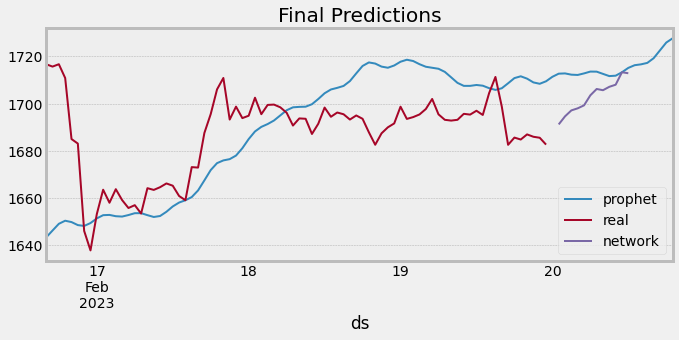

In [4]:
# Apply the best found NN model
n = 24*1
x = data[-n:].reshape(1,n*1)

from keras.models import load_model
model = load_model('develop/training/d12-1_24_12/2023-02-20_012429.h5')
pred_nn = model(x)[0]

# transform predictions
pred_nn = pred_nn*data_std + data_mean
ind = pd.date_range(start = df.index[-1], periods = 20, freq = 'h')[1+HOLDOUT:][:12]
pred_nn = pd.Series(pred_nn, index = ind) + pred_prophet

# dataframe of predictions
df_preds = pred_prophet.reset_index().set_index('ds')
df_preds.columns = ['prophet']
df_preds['real'] = df.close
df_preds['network'] = pred_nn
df_preds.to_pickle('output/df_preds.pkl')

# plotting
_ = df_preds[-100:].plot(figsize = (10,4), title = 'Final Predictions')

### Output for Ocean

In [5]:
filt = ~df_preds['network'].isnull()
x_out = df_preds[filt].network

x_out = str(list(x_out.map(lambda x: round(x,3)))).replace(' ','')
print(x_out)
filename = 'output/eth_predict.csv'
fout = open(filename, 'w')
fout.write(x_out)
fout.close()

[1691.201,1694.625,1697.135,1698.012,1699.269,1703.525,1706.204,1705.688,1707.128,1708.018,1713.3,1712.872]
